## Import

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
rng = np.random.default_rng(123456)

import librosa
import librosa.display
import IPython.display as ipd
import copy
from scipy.io import wavfile

import os
from sklearn import neighbors

## AudioDataset class

In [105]:
sliced_dataset = "short_audio_dataset"
sliced_dataset_lenght = 16050
# sliced_dataset = "shorter_audio_dataset"
# sliced_dataset_lenght = 4013
original_dataset = "audio_dataset"
original_dataset_lenght = 80249

class AudioDataset(Dataset):
    def __init__(self, root_path="./data/", drop_both=False, use_short=False, active='wavs', normalize=False):
        root_folder = root_path + original_dataset if not use_short else root_path + sliced_dataset
        self.max_length = original_dataset_lenght if not use_short else sliced_dataset_lenght
        self.class_map = {"esben" : 0, "peter": 1, "both": 2}
        self.data = []
        self.labels = []
        self.min_val = 10e10
        self.max_val = 0
        self.normalize = normalize
        self.wavs, self.mfccs, self.chromas, self.contrasts, self.centroids, self.bandwidths = [], [], [], [], [], []
        self.wavs_norm, self.mfccs_norm, self.chromas_norm, self.contrasts_norm, self.centroids_norm, self.bandwidths_norm = [], [], [], [], [], []
        
        print("Start reading files")
        for subdir, dirs, files in os.walk(root_folder):
            for file_name in files:
                if drop_both and "both" in subdir:
                   continue
        
                file_path = os.path.join(subdir, file_name)
                self.sample_rate, wav = wavfile.read(file_path)
                wav = wav.astype(np.float32)
                
                if wav.shape[0] > self.max_length:
                    self.max_length = wav.shape[0]
                    print("Found wav with more length than specified max one, new max is:", wav.shape[0])
                
                self.feature_extraction(wav, self.sample_rate)
                wav = np.pad(wav, (0, self.max_length-wav.shape[0]))
                label_str = file_path.split('/')[-3][2:]
                label = (np.int64(self.class_map[label_str]))
                
                self.max_val = np.max(wav) if np.max(wav) > self.max_val else self.max_val
                self.min_val = np.min(wav) if np.min(wav) < self.min_val else self.min_val
                
                self.wavs.append(wav)
                self.labels.append(label)
               
        self.wavs = np.array(self.wavs)
        self.mu  = self.wavs.mean()
        self.std = np.std(self.wavs)
        # self.wavs = torch.Tensor(self.wavs)

        self.active = active
        self.values_dict = {'wavs': 0, 'mfcc': 1, 'chroma': 2, 'contrast': 3}#, 'centroid': 4, 'bandwidth': 5}
        self.values_list = [self.wavs, self.mfccs, self.chromas, self.contrasts] # self.centroids, self.bandwidths]
        self.values_norm_list = []
        for lst in self.values_list:
            self.values_norm_list.append((lst + np.abs(np.min(lst))) / (np.abs(np.min(lst)) + np.max(lst)))
            
        print("="*40)
        print("Loaded DATABASE from {}\n{} total file\nLongest file is {} long\nMean: {}\nStandard deviation: {}\n".
              format(root_folder, len(self.wavs), self.max_length, self.mu, self.std))
        print("="*40)

    def feature_extraction(self, wav, sample_rate):
        self.mfccs.append(np.transpose(np.mean(librosa.feature.mfcc(y=wav, sr=sample_rate, n_mfcc=128).T, axis=0)))
        # self.chromas.append(np.transpose(np.mean(librosa.feature.chroma_cqt(y=wav, sr=sample_rate).T, axis=0)))
        self.chromas.append(np.transpose(np.mean(librosa.feature.chroma_stft(y=wav, sr=sample_rate).T, axis=0)))
        self.contrasts.append(np.transpose(np.mean(librosa.feature.spectral_contrast(y=wav, sr=sample_rate).T, axis=0)))
        self.centroids.append(np.transpose(np.mean(librosa.feature.spectral_centroid(y=wav, sr=sample_rate).T, axis=0)))
        self.bandwidths.append(np.transpose(np.mean(librosa.feature.spectral_bandwidth(y=wav, sr=sample_rate).T, axis=0)))

    def __len__(self):
        return len(self.wavs)
    
    def __getitem__(self, idx):
        y = self.labels[idx]
        x = self.values_list[self.values_dict[self.active]][idx]
        if self.normalize:
            x = self.values_norm_list[self.values_dict[self.active]][idx]
        x = torch.Tensor(x)
        return x, y


## Loading data for training

In [106]:
audio_dataset = AudioDataset(root_path="../data/", drop_both=True, use_short=True)
dataset_len = len(audio_dataset)
train_size, test_size, valid_size = round(dataset_len * 0.7), round(dataset_len * 0.2), round(dataset_len * 0.1)

dataset_train, dataset_test, dataset_valid = torch.utils.data.random_split(audio_dataset, (train_size, test_size, valid_size))

kwargs = {'batch_size': 1, 'num_workers': 1}
loader_train = torch.utils.data.DataLoader(dataset_train, **kwargs, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, **kwargs, shuffle=True)
loader_valid = torch.utils.data.DataLoader(dataset_valid, **kwargs, shuffle=True)

Start reading files
1000
1000
1000
1000
Loaded DATABASE from ../data/short_audio_dataset
1000 total file
Longest file is 16050 long
Mean: -0.6988561153411865
Standard deviation: 2332.389404296875



## Prepare data for knn

In [29]:
train_data = []
train_labels = []
test_data = []
test_labels = []
valid_data = []
valid_labels = []
lists_data = [train_data, test_data, valid_data]
lists_labels = [train_labels, test_labels, valid_labels]

i = 0
for loader in [loader_train, loader_valid, loader_test]:
    for x, y in loader:
        lists_data[i].append(np.array(x[0]))
        lists_labels[i].append(np.array(y[0]))
    i += 1
for li in lists_data:
    print(len(li))
for li in lists_labels:
    print(len(li))

700
100
200
700
100
200


## Visualize data

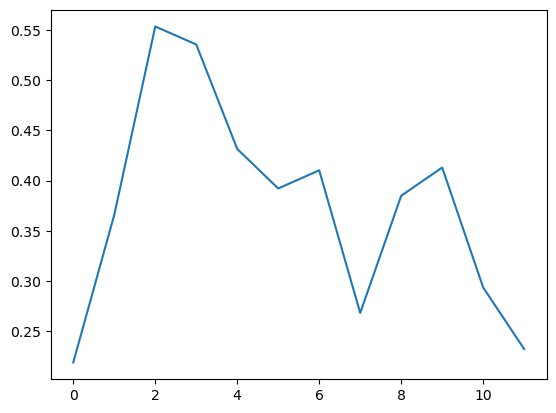

In [118]:
audio_dataset.active = 'chroma'
audio_dataset.normalize = True

for x, y in loader_test:
    plt.plot(np.arange(x.shape[1]), x.flatten())
    plt.show()
    break

## Autoencoder class

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self, input_len):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_len, 256),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(256, input_len),
            nn.Sigmoid()
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)
        
    def forward(self, x):
        return self.decode(self.encode(x))

## Training autoencoder

In [8]:
model = AutoEncoder(len(dataset_train[0][0]))
opt = torch.optim.Adam(model.parameters())

for epoch in range(25):
    print(f'Epoch {epoch+1:02}/25', end=' ')
    for x, _ in loader_train:  
        x_rec = model(x) 
        loss = F.binary_cross_entropy(x_rec, x)
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        mse = F.mse_loss(x_rec, x)
        mae = F.l1_loss(x_rec, x)
        
    print(f'loss: {loss.item():.4f} - rmse: {np.sqrt(mse.item()):.4f} - mae: {mae.item():.4f}')

Epoch 01/25 

RuntimeError: all elements of target should be between 0 and 1

## Define KNN

In [ ]:
def knn_param_search(train_data, train_labels, test_data, test_labels, 
                     metrics=('manhattan', 'euclidean', 'chebyshev'), 
                     ks=(1, 3, 5, 10, 25, 50, 100, 250), 
                     n_train=None, n_test=None, algorithm='brute'):
  """
  Takes a dataset and plots knn classification accuracy 
  for different hyper parameters.

  n_train and n_test allows to subsample the dataset for faster iteration
  """
  x_train = np.array(train_data)
  y_train = np.array(train_labels)
  x_test = np.array(test_data)
  y_test = np.array(test_labels)
  max_acc = 0
  for metric in metrics:
    for k in ks:
        print(f'Metric: {metric}; k: {k:3};', end=' ')
        classifier = neighbors.KNeighborsClassifier(k, algorithm=algorithm, metric=metric)
        classifier = classifier.fit(x_train, y_train)

        labels = classifier.predict(x_test)
        
        correct = labels == np.array(y_test)
        print(f'Accuracy: {correct.mean() * 100:.2f}%')
        if correct.mean() > max_acc:
           max_acc = correct.mean()
           best_classifier = classifier
           best_metric = metric
           best_k = k
  print(f'Best classifier | metric: {best_metric}; k: {best_k:3}; accuracy: {max_acc * 100:.2f}%')
  return best_classifier

## Call KNN

In [ ]:
classifier = knn_param_search(train_data, 
                              train_labels, 
                              test_data,
                              test_labels,
                            #   metrics=['euclidean'],
                              ks=(1, 3, 5, 10, 25, 50, 100)
                             )

Metric: manhattan; k:   1; Accuracy: 80.00%
Metric: manhattan; k:   3; Accuracy: 80.00%
Metric: manhattan; k:   5; Accuracy: 76.67%
Metric: manhattan; k:  10; Accuracy: 73.33%
Metric: manhattan; k:  25; Accuracy: 80.00%
Metric: manhattan; k:  50; Accuracy: 73.33%
Metric: manhattan; k: 100; Accuracy: 70.00%
Metric: euclidean; k:   1; Accuracy: 56.67%
Metric: euclidean; k:   3; Accuracy: 53.33%
Metric: euclidean; k:   5; Accuracy: 56.67%
Metric: euclidean; k:  10; Accuracy: 60.00%
Metric: euclidean; k:  25; Accuracy: 66.67%
Metric: euclidean; k:  50; Accuracy: 66.67%
Metric: euclidean; k: 100; Accuracy: 50.00%
Metric: chebyshev; k:   1; Accuracy: 53.33%
Metric: chebyshev; k:   3; Accuracy: 60.00%
Metric: chebyshev; k:   5; Accuracy: 50.00%
Metric: chebyshev; k:  10; Accuracy: 40.00%
Metric: chebyshev; k:  25; Accuracy: 50.00%
Metric: chebyshev; k:  50; Accuracy: 46.67%
Metric: chebyshev; k: 100; Accuracy: 46.67%
Best classifier | metric: manhattan; k:   1; accuracy: 80.00%


In [ ]:
predicted_labels = classifier.predict(valid_data)
correct = predicted_labels == np.array(valid_labels)
print(f' Accuracy: {correct.mean() * 100:.2f}')

 Accuracy: 61.67


## Result from KNN

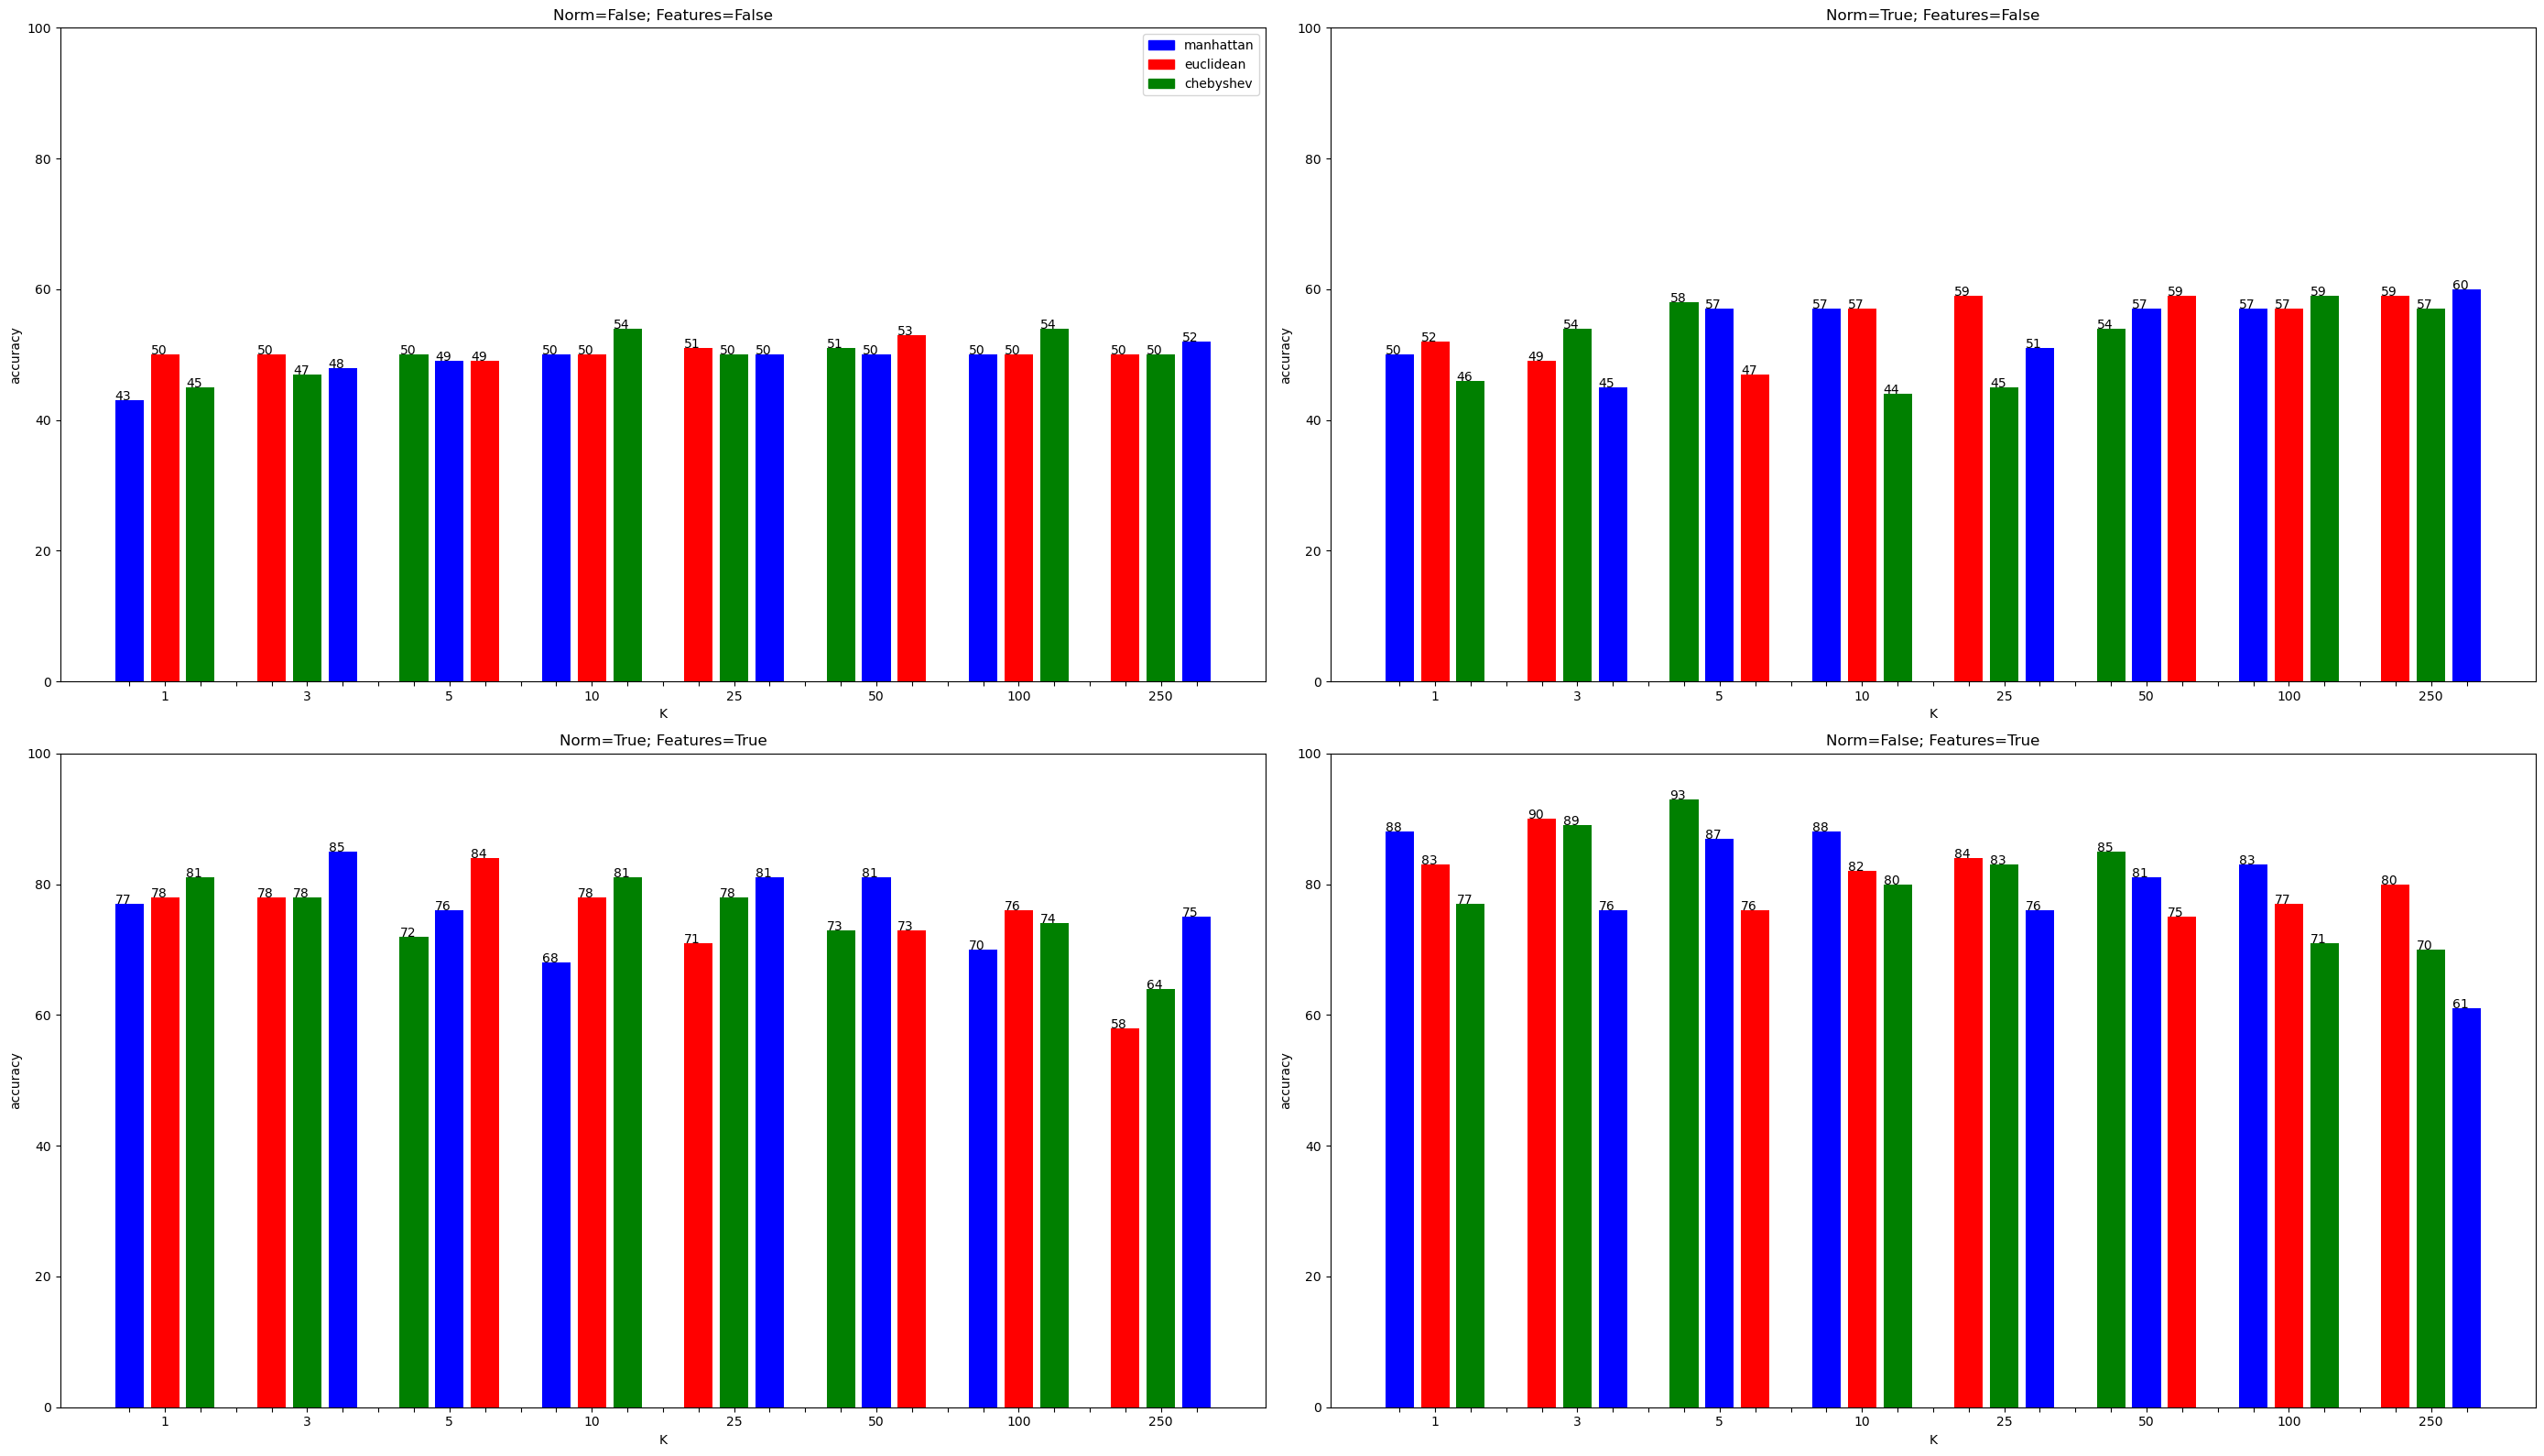

In [32]:
no_norm_no_feat = [43.00, 50.00, 50.00, 50.00, 51.00, 51.00, 50.00, 50.00, 50.00, 47.00, 49.00, 50.00, 50.00, 50.00, 50.00, 50.00, 45.00, 48.00, 49.00, 54.00, 50.00, 53.00, 54.00, 52.00]
norm_no_feat = [50.00, 49.00, 58.00, 57.00, 59.00, 54.00, 57.00, 59.00, 52.00, 54.00, 57.00, 57.00, 45.00, 57.00, 57.00, 57.00, 46.00, 45.00, 47.00, 44.00, 51.00, 59.00, 59.00, 60.00]
norm_feat = [77.00, 78.00, 72.00, 68.00, 71.00, 73.00, 70.00, 58.00, 78.00, 78.00, 76.00, 78.00, 78.00, 81.00, 76.00, 64.00, 81.00, 85.00, 84.00, 81.00, 81.00, 73.00, 74.00, 75.00]
no_norm_feat = [88.00, 90.00, 93.00, 88.00, 84.00, 85.00, 83.00, 80.00, 83.00, 89.00, 87.00, 82.00, 83.00, 81.00, 77.00, 70.00, 77.00, 76.00, 76.00, 80.00, 76.00, 75.00, 71.00, 61.00]
datas = [no_norm_no_feat ,norm_no_feat ,norm_feat ,no_norm_feat]
titles = ['Norm=False; Features=False' ,'Norm=True; Features=False', 'Norm=True; Features=True', 'Norm=False; Features=True']
ks = [1, 3, 5, 10, 25, 50, 100, 250]
metrics = ['manhattan', 'euclidean', 'chebyshev']

fig = plt.figure(figsize=(28, 16))
for i, data in enumerate(datas):
    # fig = plt.figure(figsize=(32,4))
    ax = fig.add_subplot(2, 2, i+1)
    
    fig.tight_layout()
    ax.title.set_text(titles[i])    
    tmp = []
    for j in range(len(ks)):
        tmp.append(data[j])
        tmp.append(data[j+len(ks)])
        tmp.append(data[j+len(ks)*2])
        tmp.append(0)
    tmp.pop()
    clrs = ('blue', 'red', 'green') * len(ks)

    bars = plt.bar(range(len(tmp)), tmp, width=0.8, color=clrs)
    for bar in bars:
        if bar.get_height() > 0:
            ax.text(bar.get_x(), bar.get_height(), format(int(bar.get_height())))

    ax.set_ylim(0, 100)
    ax.set_ylabel('accuracy')

    ax.set_xticks(range(len(tmp)))
    x_tick_labels = []
    for k in ks:
        x_tick_labels.append('')
        x_tick_labels.append(format(k))
        x_tick_labels.append('')
        x_tick_labels.append('')
    x_tick_labels.pop()
    ax.set_xticklabels(x_tick_labels)
    ax.set_xlabel('K')

    if i == 0:
        legend_patches = [mpatches.Patch(color=clrs[0], label=metrics[0]), mpatches.Patch(color=clrs[1], label=metrics[1]), mpatches.Patch(color=clrs[2], label=metrics[2])]
        plt.legend(handles=legend_patches)
    # plt.show()
plt.show()

## Build MLP

In [8]:
# by extending nn.Module:
class MLP(nn.Module):
  def __init__(self, n_hidden_neurons: int, input_len):
    super().__init__()
    self.fc1 = nn.Linear(input_len, n_hidden_neurons)
    self.fc2 = nn.Linear(n_hidden_neurons, 2)

  def forward(self, x: torch.Tensor):
    # x = x.flatten(start_dim=0)  # (N, d_data)
    h = F.relu(self.fc1(x))
    logits = self.fc2(h)
    return logits

## Train MLP

In [9]:
all_losses, all_accuracies = {}, {}
best_accuracy = 0
best_model = None
learning_rate = 5e-2
n_epochs = 10

for n_hidden_neurons in ([10, 100, 1000, 10000]):
  print(f"Hidden neurons: {n_hidden_neurons}")
  model = MLP(n_hidden_neurons, len(dataset_train[0][0]))
  opt = torch.optim.SGD(model.parameters(), lr=learning_rate)

  train_losses, train_accuracies = [], []
  valid_losses, valid_accuracies = [], []

  for epoch in range(n_epochs):
    print(f"{epoch+1:02} / 10 Epoch", end=": ")

    epoch_losses = []
    correct, total = 0, 0
    for x, y in loader_train:
      opt.zero_grad()
  
      logits = model(x)  # logits: common name for the output before softmax activation
  
      log_probs = F.log_softmax(logits, dim=1)  # numerically stable version of log(softmax(logits))
  
      loss = F.nll_loss(log_probs, y)  # negative log likelihood loss
      # or just: loss = F.cross_entropy(logits, y)

      loss.backward()
      opt.step()
      epoch_losses.append(loss.item())
      total += len(x)
      correct += (torch.argmax(logits, dim=1) == y).sum().item()
    train_losses.append(np.mean(epoch_losses))
    train_accuracies.append(correct / total)
    print(f"Train; Loss mean: {np.mean(epoch_losses):2.2f}; Accuracy: {correct / total:2.2f}", end=" | ")
    
    epoch_losses = []
    correct, total = 0, 0
    for x, y in loader_valid:
      with torch.no_grad():
        logits = model(x)
      loss = F.cross_entropy(logits, y)

      epoch_losses.append(loss.item())
      total += len(x)
      correct += (torch.argmax(logits, dim=1) == y).sum().item()
    valid_losses.append(np.mean(epoch_losses))
    valid_accuracy = correct / total
    valid_accuracies.append(valid_accuracy)
    print(f"Valid; Loss mean: {np.mean(epoch_losses):2.2f}; Accuracy: {valid_accuracy:2.2f}")
    if valid_accuracy > best_accuracy:
      best_accuracy = valid_accuracy
      best_model = copy.deepcopy(model), n_hidden_neurons, epoch

  all_losses[n_hidden_neurons] = train_losses, valid_losses
  all_accuracies[n_hidden_neurons] = train_accuracies, valid_accuracies

Hidden neurons: 10
01 / 10 Epoch: Train; Loss mean: 0.70; Accuracy: 0.49 | Valid; Loss mean: 0.69; Accuracy: 0.53
02 / 10 Epoch: Train; Loss mean: 0.70; Accuracy: 0.49 | Valid; Loss mean: 0.70; Accuracy: 0.47
03 / 10 Epoch: Train; Loss mean: 0.70; Accuracy: 0.50 | Valid; Loss mean: 0.69; Accuracy: 0.53
04 / 10 Epoch: Train; Loss mean: 0.70; Accuracy: 0.50 | Valid; Loss mean: 0.69; Accuracy: 0.53
05 / 10 Epoch: Train; Loss mean: 0.70; Accuracy: 0.50 | Valid; Loss mean: 0.73; Accuracy: 0.47
06 / 10 Epoch: Train; Loss mean: 0.70; Accuracy: 0.50 | Valid; Loss mean: 0.69; Accuracy: 0.53
07 / 10 Epoch: Train; Loss mean: 0.70; Accuracy: 0.52 | Valid; Loss mean: 0.69; Accuracy: 0.53
08 / 10 Epoch: Train; Loss mean: 0.70; Accuracy: 0.48 | Valid; Loss mean: 0.69; Accuracy: 0.53
09 / 10 Epoch: Train; Loss mean: 0.70; Accuracy: 0.50 | Valid; Loss mean: 0.69; Accuracy: 0.53
10 / 10 Epoch: Train; Loss mean: 0.70; Accuracy: 0.50 | Valid; Loss mean: 0.70; Accuracy: 0.53
Hidden neurons: 100
01 / 10 Epo

## Results from MLP

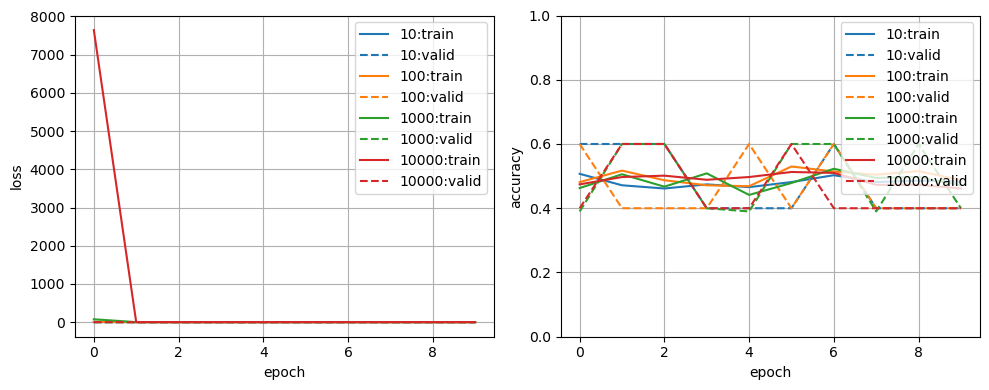

In [23]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.xlabel('epoch')
plt.ylabel('loss')
for n, (train_losses, valid_losses) in all_losses.items():
  p = plt.plot(train_losses, label=f'{n}:train')
  plt.plot(valid_losses, label=f'{n}:valid', ls='--', c=p[0].get_color())
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
for n, (train_accuracies, valid_accuracies) in all_accuracies.items():
  p = plt.plot(train_accuracies, label=f'{n}:train')
  plt.plot(valid_accuracies, label=f'{n}:valid', ls='--', c=p[0].get_color())
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# test
model, n_hidden_neurons, epoch = best_model
print(f'best val accuracy: {best_accuracy:.2f} with {n_hidden_neurons} hidden neurons after {epoch} epoch')

correct, total = 0, 0
for x, y in loader_valid:
  with torch.no_grad():
    logits = model(x)
  total += len(x)
  correct += (torch.argmax(logits, dim=1) == y).sum().item()
print(f'test accuracy: {correct / total:.2f}')

best val accuracy: 0.71 with 10000 hidden neurons after 4 epoch
test accuracy: 0.71
